In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
%matplotlib inline

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=True)

In [ ]:
for images, _ in train_dl:
  print(f'images shape: {images.shape}')
  break

images shape: torch.Size([128, 1, 28, 28])


images shape: torch.Size([128, 1, 28, 28])


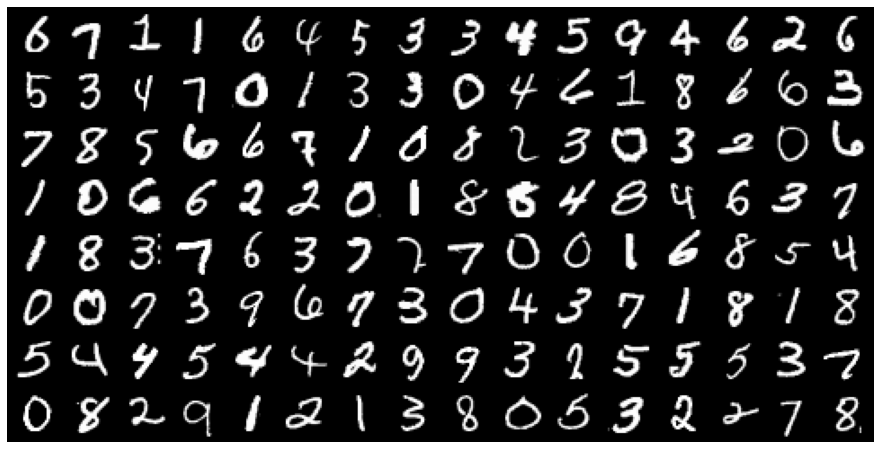

In [ ]:
for images, _ in train_dl:
  print(f'images shape: {images.shape}')
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
  break

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class MnistModel(nn.Module):
  """ Feedforward neural network with 1 hidden layer"""
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    # output layer
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    # Flatten image tensors
    xb = xb.view(xb.size(0), -1)
    # Get intermediate outputs using hidden layer
    out = self.linear1(xb)
    # Apply activation function
    out = F.relu(out)
    # Get predictions of the output layer
    out = self.linear2(out)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, result):
    batch_losses = [x['val_loss'] for x in result]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in result]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f'Epoch [{epoch}], val_loss: {round(result["val_acc"], 4)}, val_acc: {round(result["val_acc"], 4)}')

In [ ]:
in_size = 784
hidden_size = 32 # can change this
num_classes = 10

In [ ]:
model = MnistModel(in_size, hidden_size, num_classes)

In [ ]:
model

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images, labels in train_dl:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print(f'Loss: {loss}')
  break

print(f'outputs shape: {outputs.shape}')
print(f'sample outputs:\n {outputs[:2].data}')

Loss: 2.3014256954193115
outputs shape: torch.Size([128, 10])
sample outputs:
 tensor([[-0.0487,  0.1434, -0.1077, -0.0516, -0.2041,  0.1034, -0.0193, -0.0306,
         -0.0244, -0.0440],
        [ 0.0498,  0.0380, -0.1037,  0.0189, -0.1281,  0.0436, -0.0419,  0.0436,
         -0.0356, -0.0423]])


## Using a GPU

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
  """Pick GPU if avaliable, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
  '''Move tensor(s) to chosen device'''
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
for images, labels in train_dl:
  print(images.device)
  break

cpu


In [ ]:
for images, labels in train_dl:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cuda:0


In [ ]:
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

In [ ]:
for xb, yb in val_loader:
  print(f'xb.device: {xb.device}')
  print(f'yb: {yb}')
  break

xb.device: cuda:0
yb: tensor([2, 1], device='cuda:0')


##Training the model

In [ ]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)



def fit(n_epochs, model, train_dl, val_dl, lr, opt_f=torch.optim.SGD):
  history = []
  opt = opt_f(model.parameters(), lr)

  for epoch in range(n_epochs):
    for batch in train_dl:
      loss = model.training_step(batch)
      loss.backward()
      opt.step()
      opt.zero_grad()

    result = evaluate(model, val_dl)
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [ ]:
# Model (on GPU)
model = MnistModel(in_size, hidden_size, num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.06939999759197235, 'val_loss': 2.317108392715454}]

In [ ]:
n_epochs = 5
lr = 0.5
history += fit(n_epochs, model, train_loader, val_loader, lr)

Epoch [0], val_loss: 0.9218, val_acc: 0.9218
Epoch [1], val_loss: 0.9472, val_acc: 0.9472
Epoch [2], val_loss: 0.9509, val_acc: 0.9509
Epoch [3], val_loss: 0.9558, val_acc: 0.9558
Epoch [4], val_loss: 0.9621, val_acc: 0.9621


In [ ]:
n_epochs = 5
lr = 0.1
history += fit(n_epochs, model, train_loader, val_loader, lr)

Epoch [0], val_loss: 0.9652, val_acc: 0.9652
Epoch [1], val_loss: 0.965, val_acc: 0.965
Epoch [2], val_loss: 0.9645, val_acc: 0.9645
Epoch [3], val_loss: 0.9658, val_acc: 0.9658
Epoch [4], val_loss: 0.9657, val_acc: 0.9657


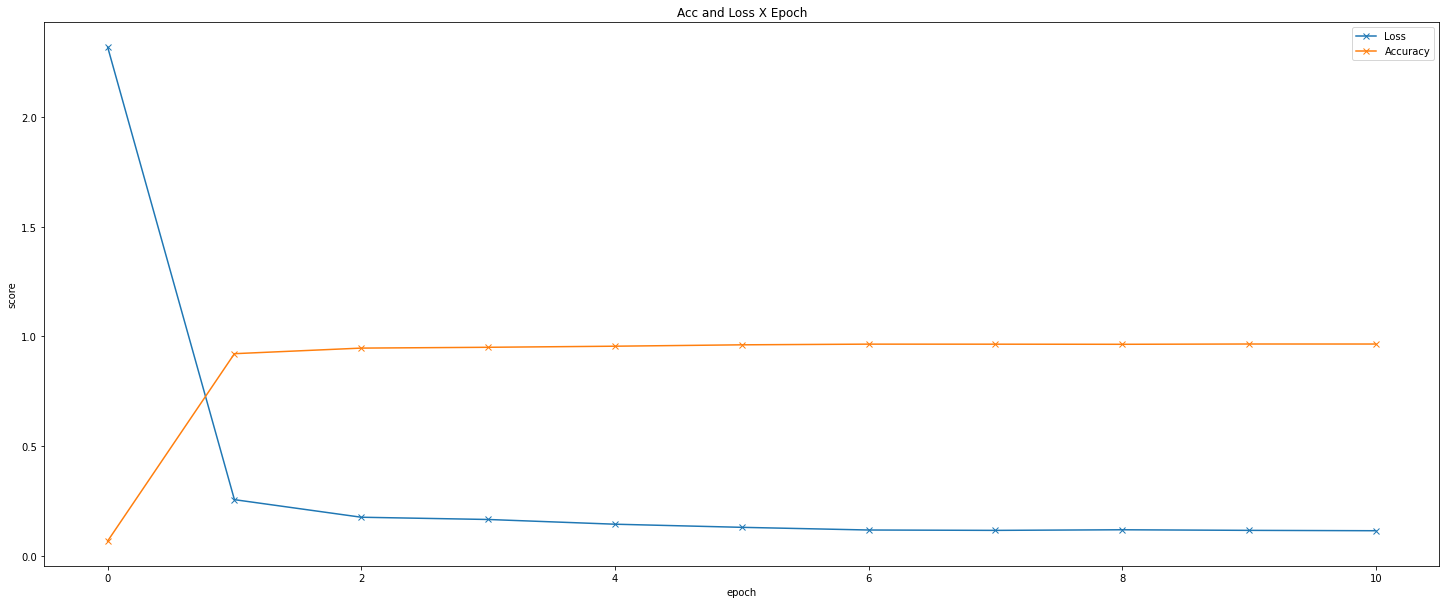

In [ ]:
losses = [x['val_loss'] for x in history]
accs = [x['val_acc'] for x in history]

plt.figure(figsize=(25, 10))

plt.plot(losses, '-x', label='Loss')
plt.plot(accs, '-x', label='Accuracy')
plt.xlabel('epoch')
plt.ylabel('score')
plt.title('Acc and Loss X Epoch')
plt.legend();

In [ ]:
torch.save(model.state_dict(), 'mnist-ffnn.sth')

In [ ]:
# mount it
%cd '/content/drive/MyDrive/kaggle competitions'
# copy it there
!cp /content/mnist-ffnn.sth '/content/drive/MyDrive/kaggle competitions'

/content/drive/MyDrive/kaggle competitions
